 # Quick comparison of PCN and BioPCN on MNIST

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch
import time

from cpcn import *
from cpcn.graph import *

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# get train, validation, and test loaders for MNIST
dataset = load_mnist(n_validation=1000, device=device)

 ## Train PCN

In [3]:
n_batches = 3000
dims = [784, 30, 5, 10]
z_it = 50
z_lr = 0.062
rho = 0.015
# rho = 0.0012

t0 = time.time()
torch.manual_seed(123)

net = PCNetwork(
    dims,
    activation="none",
    z_lr=z_lr,
    z_it=z_it,
    variances=1.0,
    constrained=True,
    rho=rho,
    bias=False,
)
net = net.to(device)

optimizer = multi_lr(
    torch.optim.SGD, net.parameter_groups(), lr_factors={"Q": 0.11}, lr=0.01
)
lr_power = 1.0
lr_rate = 4e-4
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda batch: 1 / (1 + lr_rate * batch ** lr_power)
)
trainer = Trainer(dataset["train"])
trainer.metrics["accuracy"] = one_hot_accuracy
for batch in tqdmw(trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(net)
    ns = batch.feed(net)
    optimizer.step()
    scheduler.step()

results = trainer.history
print(f"Training PCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/3000 [00:00<?, ?it/s]

Training PCN took 96.0 seconds.


 ### Show PCN learning curves

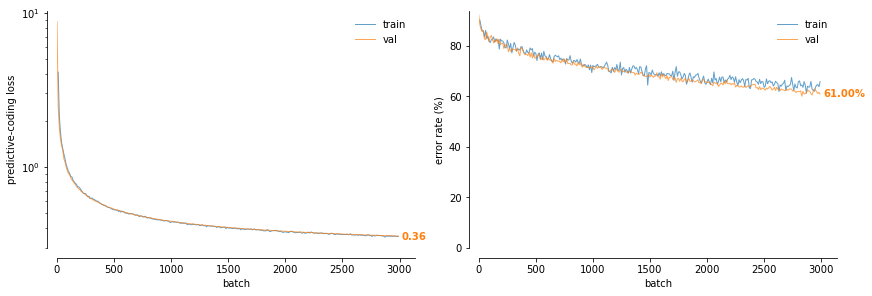

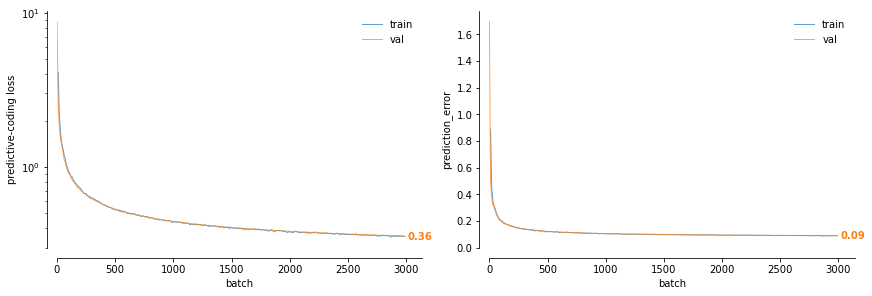

In [4]:
_ = show_learning_curves(results)
_ = show_learning_curves(results, var_names=("pc_loss", "prediction_error"))

 ## Train BioPCN

In [5]:
z_it = 50
z_lr = 0.13

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)
biopcn_net = biopcn_net.to(device)

biopcn_optimizer = multi_lr(
    torch.optim.SGD, biopcn_net.parameter_groups(), lr_factors={"Q": 3.5}, lr=0.003
)
lr_power = 1.0
lr_rate = 2e-4
biopcn_scheduler = torch.optim.lr_scheduler.LambdaLR(
    biopcn_optimizer, lr_lambda=lambda batch: 1 / (1 + lr_rate * batch ** lr_power)
)
biopcn_trainer = Trainer(dataset["train"])
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)
    ns = batch.feed(biopcn_net)
    biopcn_optimizer.step()
    biopcn_scheduler.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/3000 [00:00<?, ?it/s]

Training BioPCN took 100.1 seconds.


 ### Show BioPCN learning curves

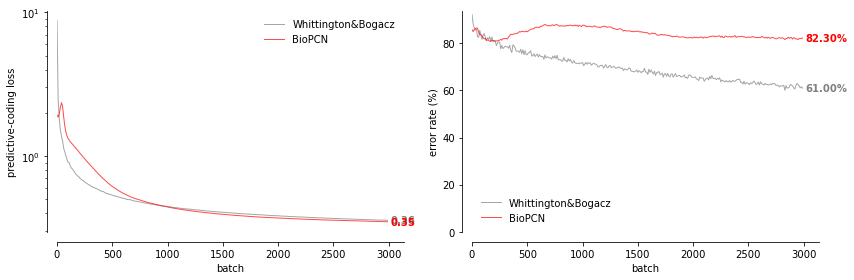

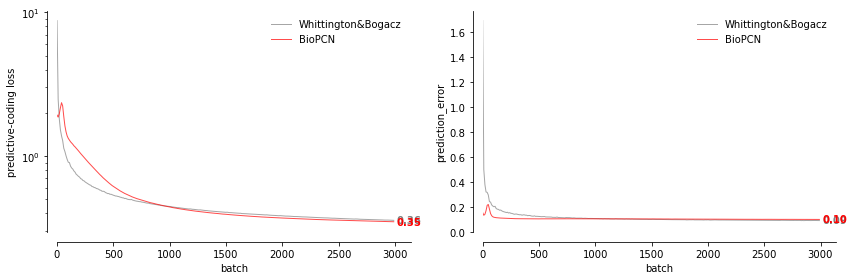

In [6]:
with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        axs=axs,
    )

with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        var_names=("pc_loss", "prediction_error"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        var_names=("pc_loss", "prediction_error"),
        axs=axs,
    )